<a href="https://colab.research.google.com/github/pramodkoujalagi/Char-isma/blob/main/Char_isma_ML_BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Char-imsa sprinkled with Batch Normalization

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
characters = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(characters)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3

def dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      Xi = stoi[ch]
      X.append(context)
      Y.append(Xi)
      context = context[1:] + [Xi]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
g1 = int(0.8*len(words))
g2 = int(0.9*len(words))

X_train, Y_train = dataset(words[:g1])
X_val, Y_val = dataset(words[g1:g2])
X_test, Y_test = dataset(words[g2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


By setting the seed for a generator, ensuring that the same sequence of random numbers is generated every time code is run. This is crucial for debugging and reproducing results.

In [6]:
n_embeddings = 10 # The dimensionality of the character embedding vectors
n_hidden = 200 # The number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(67280421310721)
C = torch.randn((vocab_size, n_embeddings),               generator=g)
W1 = torch.randn((n_embeddings*block_size, n_hidden), generator=g) * (5/3)/((n_embeddings*block_size)*0.5) # for tanh
#b1 = torch.randn(n_hidden,                            generator=g)
W2 = torch.randn((n_hidden, vocab_size),              generator=g) * 0.01
b2 = torch.randn(vocab_size,                          generator=g) * 0


# Params for BatchNorm
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

params = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in params))
for p in params:
  p.requires_grad = True

12097


In [12]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini batch
  Xi = torch.randint(0, X_train.shape[0], (batch_size,), generator=g) # (0, 182625, (32,), generator=g)
  Xb, Yb = X_train[Xi], Y_train[Xi] # batch X, Y

  # forward pass
  emb = C[Xb] # embedding the characters into vectors
  emb_cat = emb.view(emb.shape[0], -1) # (32, -1)

  # Linear layer
  hpreact = emb_cat @ W1 # hidden layer pre-activation

  # Batch Normalization layer
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / (bnstdi + 1e-5) + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in params:
    p.data += -lr * p.grad

  # tracking stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 2.1474
  10000/ 200000: 2.2200
  20000/ 200000: 2.1465
  30000/ 200000: 2.0795
  40000/ 200000: 1.8882
  50000/ 200000: 2.8055
  60000/ 200000: 2.1742
  70000/ 200000: 2.0444
  80000/ 200000: 2.0505
  90000/ 200000: 2.2517
 100000/ 200000: 2.1956
 110000/ 200000: 1.9765
 120000/ 200000: 2.1291
 130000/ 200000: 1.7016
 140000/ 200000: 1.8407
 150000/ 200000: 1.9884
 160000/ 200000: 1.7303
 170000/ 200000: 2.1841
 180000/ 200000: 2.2743
 190000/ 200000: 2.0441


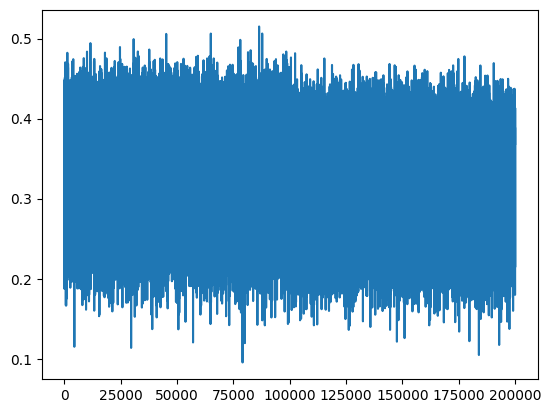

In [13]:
plt.plot(lossi)

In [14]:
with torch.no_grad():
  # passing the training set
  emb = C[X_train]
  emb_cat = emb.view(emb.shape[0], -1)
  hpreact = emb_cat @ W1

  # measuring the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [15]:
@torch.no_grad() # disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, Y_train),
    'val': (X_val, Y_val),
    'test': (X_test, Y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = emb_cat @ W1 # + b1
  hpreact = bngain * ((hpreact - bnmeani) / (bnstd)) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0727527141571045
val 2.1200315952301025


## Making it similar to Pytorch

In [86]:
# Deep network, compared to previous one
# The classes below are the same API as nn.Module in PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    #parameters trained with backpropagation
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers - trained iwth running 'momentum update'
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculating the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta

    # updating the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # Dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # making last layer less confident
  layers[-1].gamma *= 0.1
  #applying gain for all the layers
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [87]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  Xi = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[Xi], Y_train[Xi] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concat the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # should remove after dbg
  for p in parameters:
    p.grad = None
  loss.backward()

  # update learning rate
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # printing for every 10K steps
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
  #   break

      0/ 200000: 3.2870
  10000/ 200000: 2.3273
  20000/ 200000: 2.1019
  30000/ 200000: 1.9020
  40000/ 200000: 2.1643
  50000/ 200000: 2.1520
  60000/ 200000: 1.7767
  70000/ 200000: 2.1514
  80000/ 200000: 2.3802
  90000/ 200000: 1.9338
 100000/ 200000: 2.3943
 110000/ 200000: 2.1507
 120000/ 200000: 2.1813
 130000/ 200000: 2.0889
 140000/ 200000: 1.8096
 150000/ 200000: 1.9133
 160000/ 200000: 1.9793
 170000/ 200000: 1.9654
 180000/ 200000: 2.2462
 190000/ 200000: 1.9601


layer 2 (      Tanh): mean +0.01, std 0.70, saturated: 17.69%
layer 5 (      Tanh): mean -0.02, std 0.75, saturated: 21.62%
layer 8 (      Tanh): mean +0.01, std 0.78, saturated: 21.47%
layer 11 (      Tanh): mean +0.01, std 0.79, saturated: 23.25%
layer 14 (      Tanh): mean +0.02, std 0.81, saturated: 25.47%


Text(0.5, 1.0, 'activation distribution')

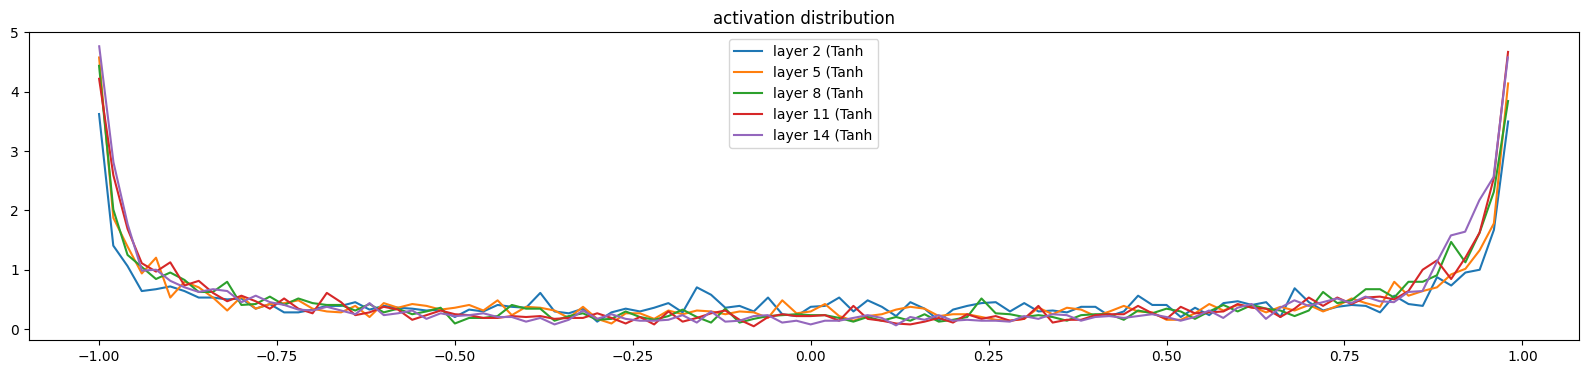

In [88]:
# histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.682804e-03
layer 5 (      Tanh): mean -0.000000, std 3.489737e-03
layer 8 (      Tanh): mean -0.000000, std 3.604941e-03
layer 11 (      Tanh): mean +0.000000, std 3.117647e-03
layer 14 (      Tanh): mean +0.000000, std 3.502808e-03


Text(0.5, 1.0, 'gradient distribution')

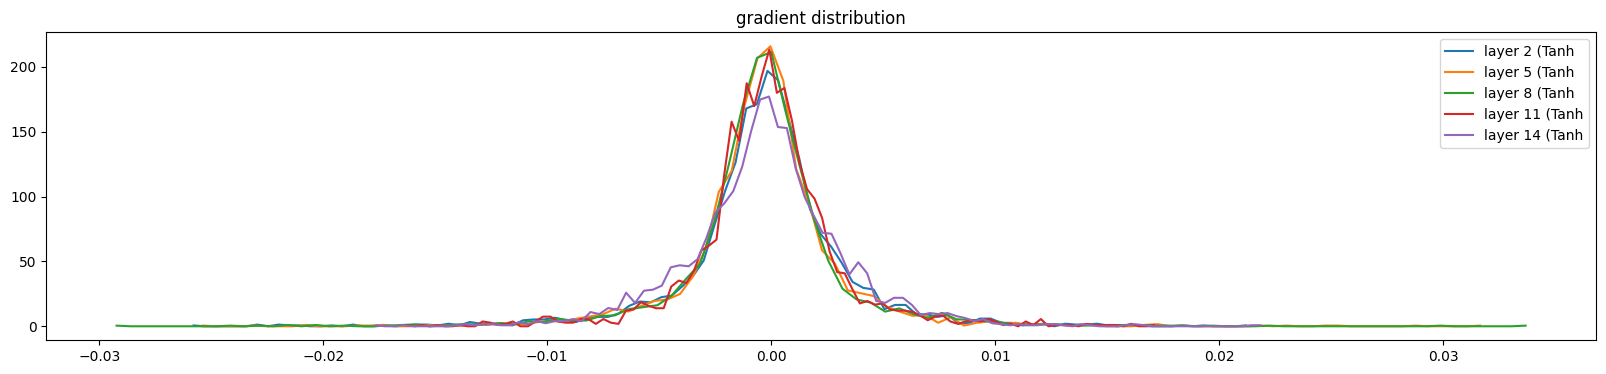

In [89]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.841559e-02 | grad:data ratio 1.619721e-02
weight  (30, 100) | mean -0.000044 | std 9.194667e-03 | grad:data ratio 2.290679e-02
weight (100, 100) | mean +0.000048 | std 5.665680e-03 | grad:data ratio 2.324884e-02
weight (100, 100) | mean +0.000033 | std 5.441663e-03 | grad:data ratio 2.262012e-02
weight (100, 100) | mean +0.000047 | std 5.277465e-03 | grad:data ratio 2.292385e-02
weight (100, 100) | mean +0.000001 | std 4.858364e-03 | grad:data ratio 2.253465e-02
weight  (100, 27) | mean -0.000082 | std 7.756864e-03 | grad:data ratio 2.193141e-02


Text(0.5, 1.0, 'weights gradient distribution')

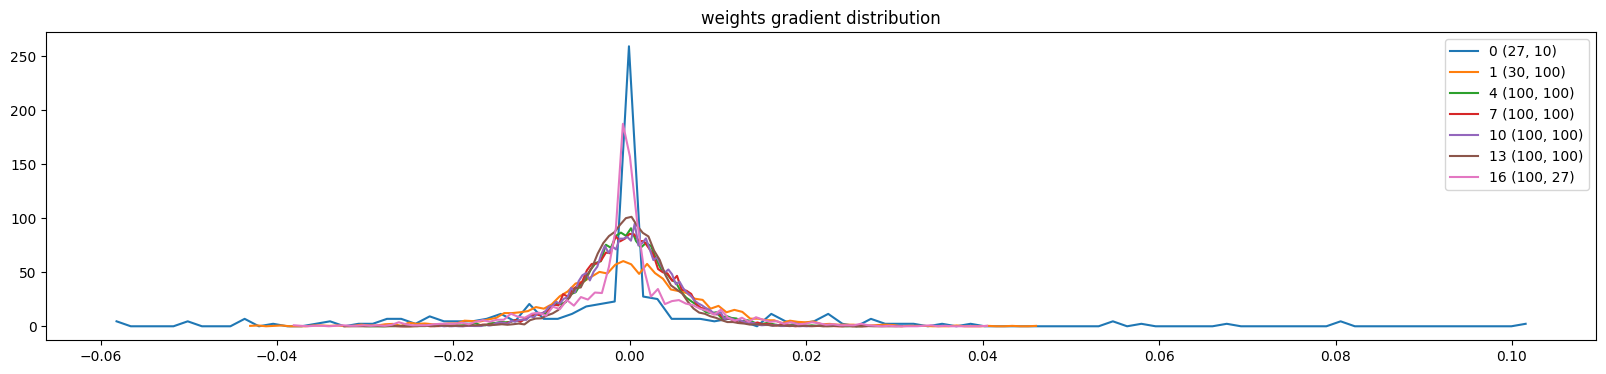

In [90]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


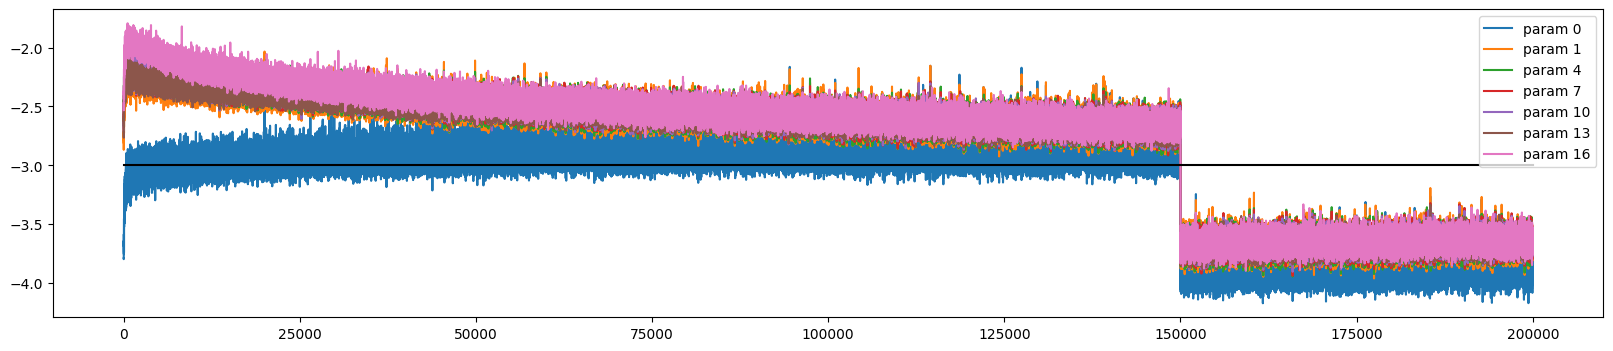

In [91]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # ratios should be ~1e-3
plt.legend(legends)

In [92]:
@torch.no_grad() # disables gradient tracking
def split_loss(split):
  x,y = {
      'train':(X_train, Y_train),
      'val': (X_val, Y_val),
      'test': (X_test, Y_test),
  }[split]

  emb = C[x] # (N, block_size * n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# putting layers int evaluation mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.999863624572754
val 2.077087879180908


In [93]:
# sample from the model
g = torch.Generator().manual_seed(67280421310721 + 5)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
      # forward passing the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1)
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)

      # sample from the distribution
      Xi = torch.multinomial(probs, num_samples=1, generator=g).item()

      # shift the context window and track the samples
      context = context[1:] + [Xi]
      out.append(Xi)

      # if the special token '.', then break
      if Xi == 0:
        break
    print(''.join(itos[i] for i in out)) # decoding and printing the generated word

kaeda.
khalania.
athiana.
nashubhileightensona.
danrosdl.
koryn.
wrothl.
cathonya.
rusca.
tanvirgvace.
nocbetyannalin.
adric.
lucarlin.
arin.
keymarchine.
mavreevan.
hamela.
narzion.
siber.
rennie.
